In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [9]:

# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement_tbl = Base.classes.measurement
Station_tbl = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.

MaxDate = engine.execute("SELECT MAX(date) FROM Measurement").first()
print(MaxDate[0])

2017-08-23


The last 12 months are from 2016-08-23 to 2017-08-23


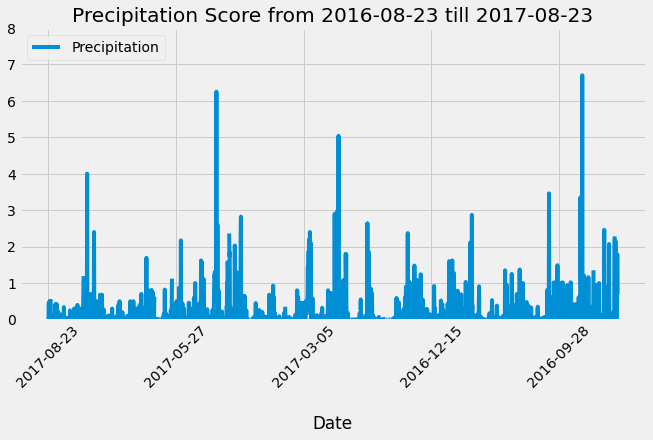

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.


# Calculate the date one year from the last date in data set.
MaxDate = engine.execute("SELECT MAX(date) FROM Measurement").fetchall()
EndDate = MaxDate[0][0]

Year = int(EndDate[0:4])
Month = int(EndDate[5:7])
Day = int(EndDate[8:])

StartDate = dt.date(Year, Month, Day) - dt.timedelta(days=365)
print(f"The last 12 months are from {StartDate} to {EndDate}")

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement_tbl.date,Measurement_tbl.prcp)\
                          .filter(Measurement_tbl.date <= EndDate)\
                          .filter(Measurement_tbl.date >= StartDate)\
                          .order_by(Measurement_tbl.date.desc()).all()
prcp_data

# Save the query results as a Pandas DataFrame and set the index to the date column
column_names = ["Date","Precipitation"]
prcp_df = pd.DataFrame(prcp_data, columns = column_names)
prcp_df.set_index("Date",inplace=True)

prcp_df.head(2)

# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot(figsize=(10,5),ylim=(0,8),title=f'Precipitation Score from {StartDate} till {EndDate}',\
                  label="Precipitation",rot=45)
plt.legend(loc="upper left")
plt.xlabel("\nDate")
plt.show()



In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation dat

prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station_tbl).count()
print(f'Total number of stations is: {stations}')

Total number of stations is: 9


In [24]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement_tbl.station, func.count(Measurement_tbl.station)).\
    group_by(Measurement_tbl.station).order_by(func.count(Measurement_tbl.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
Station = session.query(Measurement_tbl.station, func.count(Measurement_tbl.station)).\
    group_by(Measurement_tbl.station).order_by(func.count(Measurement_tbl.station).desc()).first()

Stations_temp = session.query(func.min(Measurement_tbl.tobs), func.max(Measurement_tbl.tobs), func.avg(Measurement_tbl.tobs)).\
    filter(Measurement_tbl.station == 'USC00519281').all()

print(f"The most active station is {Station[0]} with its lowest temperature, highest temperature, and average temperature.")
print()
print("Lowest   Highest  Average")

for temp in Stations_temp:
    print("---------------------------")
    print(f"{round(temp[0],2)}     {round(temp[1],2)}     {round(temp[2],2)}")

The most active station is USC00519281 with its lowest temperature, highest temperature, and average temperature.

Lowest   Highest  Average
---------------------------
54.0     85.0     71.66


<function matplotlib.pyplot.show(*args, **kw)>

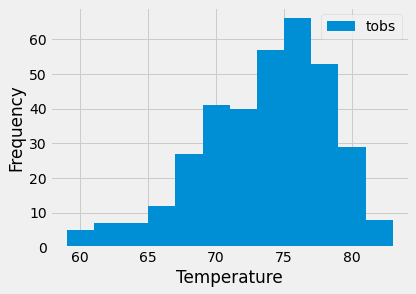

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
from pandas.plotting import table
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement_tbl.tobs).\
    filter(Measurement_tbl.station == 'USC00519281').\
    filter(Measurement_tbl.date >= prev_year).all()

df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")
plt.show

# Close session

In [27]:
# Close Session
session.close()
